# CIU with Titanic data set and Random Forest model

This notebook shows exampled of how to use CIU for explaining the probability of survival for the Titanic data set, with a Random Forest model. 

We start by importing all necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import ciu as ciu

## Load and pre-process Titanic dataset. 
Read data and do some pre-processing. 

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/KaryFramling/py-ciu/master/ciu_tests/data/titanic.csv")
data = data.drop(data.columns[0], axis=1)
unused = ['PassengerId','Cabin','Name','Ticket']
for col in unused:
    data = data.drop(col, axis=1)
from sklearn.preprocessing import LabelEncoder
data = data.dropna().apply(LabelEncoder().fit_transform)
# Split the data into training and testing sets
X = data.drop('Survived', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, data.Survived, test_size=0.2, random_state=42)


Train:

In [3]:
np.random.seed(26) # We want to always get the same Random Forest model here.
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier()

We still have a look at the accurary to at least get an idea about if the model makes sense:

In [4]:
# Make predictions on the training set
y_pred = model.predict(X_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
# Print classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.78

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        80
           1       0.77      0.70      0.73        63

    accuracy                           0.78       143
   macro avg       0.78      0.77      0.77       143
weighted avg       0.78      0.78      0.77       143



78% is not the best possible but will be good enough for the moment. Then we create the instance to explain:

In [5]:
new_passenger = pd.DataFrame.from_dict({"Pclass" : [1], "Sex": [1], "Age": [8], "SibSp": [0], "Parch": [0], "Fare": [72], "Embarked": [1]})

Let's check out some basic things about the trained model and the instance. IMPORTANT: The Random Forest model will be different at every training run so the results may vary even quite a lot. 

In [6]:
surv_prob = model.predict_proba(new_passenger)
print(f"The estimated probability of survival is {surv_prob[0,1]:.2f}.")
titanic_train_probs = model.predict_proba(X_train)
mean_surv_prob = np.mean(titanic_train_probs[:,1])
print(f"The mean probability of survival in the training set is {mean_surv_prob:.2f}.")

The estimated probability of survival is 0.64.
The mean probability of survival in the training set is 0.40.


If we want to make a distinction between numerical (floating point) features and integer/symbolic features, then we need to tell CIU what to use as integer/symbolic values using a "category mapping" dictionary. If the values are strings, then they are replaced with the corresponding index for passing to the model. If the values are integers, they are used as such as input values to the model. 

It is important to make this distinction between features also because the perturbation strategy used by CIU depends on it. If no mapping is provided, then all features will be perturbed using random float values within the given min-max range of each feature. 

*Remark*: This is not needed in "R" because ML models and (correctly implemented) XAI methods know how to use the "factor" type for this purpose. 

In [7]:
category_mapping = {
    'Sex': ['female','male'],
    'Pclass': list(range(max(data.Pclass))),
    'SibSp': list(range(max(data.SibSp))),
    'Parch': list(range(max(data.Parch))),
    'Embarked': ["Belfast","Cherbourg","Queenstown","Southampton"]
}

Create CIU object and get explanation:

We use the mean probability of survival as the 'normalCU' value of Contextual influence for consistency with the SHAP example further down. Here we show a bar chart using Contextual Influence:

In [8]:
CIU_titanic = ciu.CIU(model.predict_proba, ['No', 'Yes'], data=X_train, category_mapping=category_mapping)
CIUres = CIU_titanic.explain(new_passenger, output_inds=1)
display(CIUres)

,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
Pclass,0.000000,0.000000,-0.000000,Yes,0.64,Pclass,0.64,0.640000,[0],[1],0.5,None,None
Sex,0.233333,0.000000,-0.116667,Yes,0.64,Sex,0.64,0.873333,[1],[1],0.5,None,None
Age,0.640000,0.906250,0.260000,Yes,0.64,Age,0.06,0.700000,[2],[8],0.5,None,None
SibSp,0.230000,0.826087,0.075000,Yes,0.64,SibSp,0.45,0.680000,[3],[0],0.5,None,None
Parch,0.160000,0.000000,-0.080000,Yes,0.64,Parch,0.64,0.800000,[4],[0],0.5,None,None
Fare,0.210000,0.666667,0.035000,Yes,0.64,Fare,0.50,0.710000,[5],[72],0.5,None,None
Embarked,0.070000,1.000000,0.035000,Yes,0.64,Embarked,0.57,0.640000,[6],[1],0.5,None,None


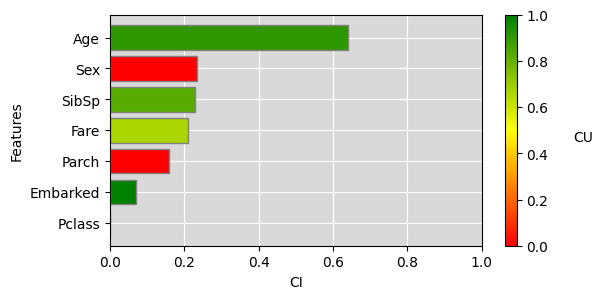

In [9]:
CIU_titanic.plot_ciu(CIUres, figsize=(6,3))

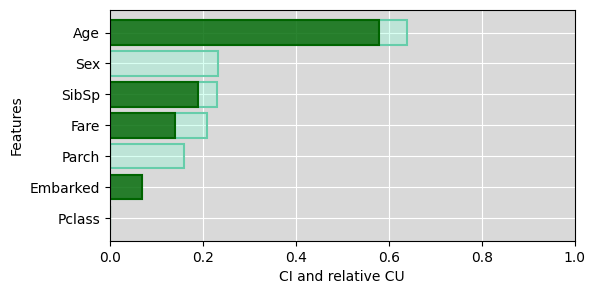

In [10]:
CIU_titanic.plot_ciu(CIUres, plot_mode='overlap', figsize=(6,3))

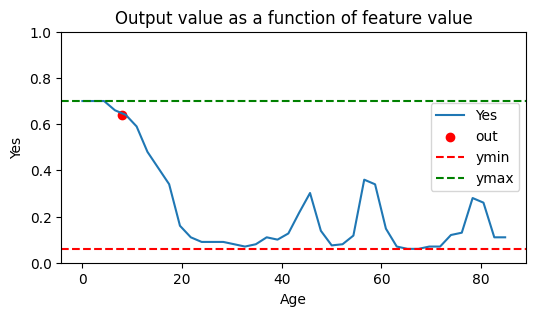

In [11]:
CIU_titanic.plot_input_output(ind_input=2, output_inds=1, legend_location=0, illustrate_CIU=True, figsize=(6,3))

It is also possible to plot the output value as a function of categorical inputs, in which case we use bars instead of a line. In this case, ``ind_outputs``can only take one value, not a list of values. 

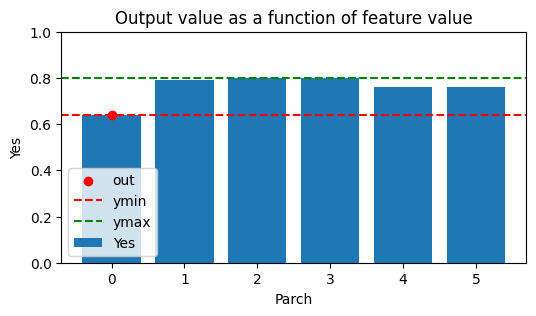

In [12]:
CIU_titanic.plot_input_output(ind_input=4, output_inds=1, illustrate_CIU=True, legend_location=0, figsize=(6,3))

This plot also works when the categorical values are strings:

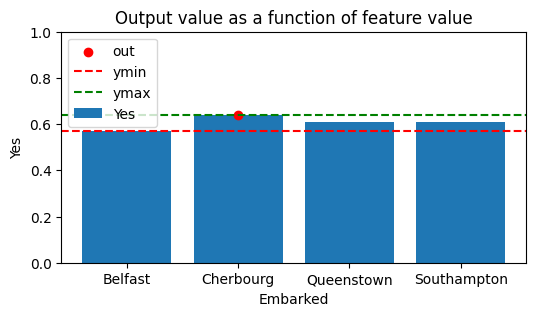

In [13]:
CIU_titanic.plot_input_output(ind_input=6, output_inds=1, illustrate_CIU=True, legend_location=0, figsize=(6,3))

It is also possible to use "Contextual influence" values for producing a similar plot as is often used for LIME and Shapley values. Here, the ``neutralCU`` parameter of CIU determines what to use as the "baseline/reference value". The default value ``neutralCU=0.5`` signifies "averagely good" but it can be set to any value that makes sense for the application at hand. 

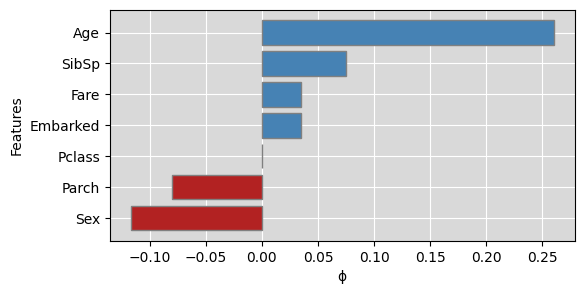

In [14]:
CIU_titanic.plot_influence(CIUres, figsize=(6,3))

For direct comparison with Shapley values, for instance, ``neutralCU`` should be set to the CU values that corresponds to the average output value. This can be done like this:

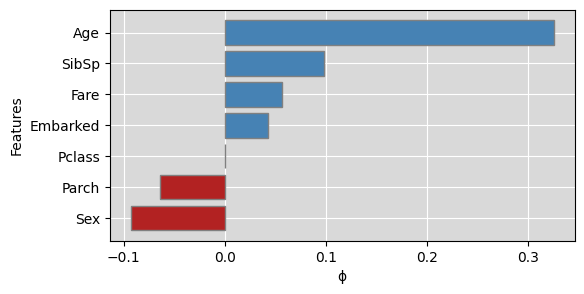

In [15]:
CIUres = CIU_titanic.explain(new_passenger, output_inds=1, neutralCU=mean_surv_prob)
CIU_titanic.plot_influence(CIUres, figsize=(6,3))

### Shapley values / SHAP

When trying to run this with Python version 3.12.1, we get the following error message: *RuntimeError: Cannot install on Python version 3.12.1; only versions >=3.8,<3.12 are supported.*. These SHAP calculations have therefore been commented away. 

Let's see what SHAP gives as a result. In the CIU plot we have used the same colors as LIME usually does but SHAP uses the opposite colors, which might sometimes be confusing. However, the negative or positive influences are clear from the direction of the bars. 

In [16]:
# import shap
# explainer = shap.Explainer(model, X_train)
# shap_values = explainer(new_passenger)
# shap.plots.bar(shap_values[0,:,1], order=np.argsort(shap_values[0,:,1].values)[::-1])

However, when we check the base/reference values used by SHAP, we see that it's 0.45 rather than the 0.39 obtained from the mean predictions. There's no obvious explanation for this but it does affect the explanations. Let's print the values:

In [17]:
# print(shap_values.base_values) # SHAP uses these values as baseline for No/Yes survived outputs.
# print(mean_surv_prob) # This is the ratio of "Survived" predicted by the model.
# print(sum(y_train)/len(y_train)) # This is the true ratio of survival in the traning set. 

Since LIME was mentioned, let's see what LIME gives as explanation:

In [18]:
# Uncomment and execute this if LIME is not yet installed.
#%pip install pandas scikit-learn lime

First we get an Explanation object and display it:

In [19]:
from lime.lime_tabular import LimeTabularExplainer

instance = new_passenger.iloc[0]
explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['Not Survived', 'Survived'], discretize_continuous=True)
explanation = explainer.explain_instance(instance.values, model.predict_proba, num_features=len(X_train.columns))
display(explanation.as_list())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[('0.00 < Sex <= 1.00', -0.4598760952068543),
 ('Age <= 27.00', 0.13898826871379183),
 ('0.00 < Pclass <= 1.00', 0.04008762870216891),
 ('34.00 < Fare <= 81.00', -0.018435773019426883),
 ('Parch <= 0.00', -0.015417849332024608),
 ('SibSp <= 0.00', 0.008076066166181017),
 ('Embarked <= 2.00', 0.0)]

LIME's own plotting functions don't necessarily give very nice outputs here and are commented out. Apparently LIME has also started using red/green colors as per 22nov2023... 

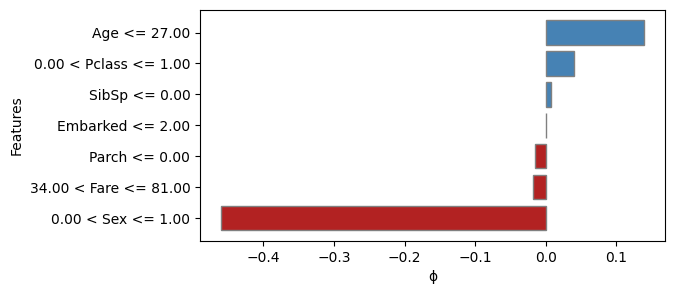

In [20]:
# LIME's own functions
#explanation.show_in_notebook()
#p = explanation.as_pyplot_figure(label=1)

# Our own plot
l = explanation.as_list()
df = pd.DataFrame(l)
feature_names = df.iloc[:,0]
infl = df.iloc[:,1]
nfeatures = len(feature_names)
fig, ax = plt.subplots(figsize=(6,3))
y_pos = np.arange(nfeatures)
infl, feature_names = (list(t) for t in zip(*sorted(zip(infl, feature_names))))
plt.xlabel("ϕ")
for m in range(len(infl)):
    ax.barh(y_pos[m], infl[m], color=["firebrick" if infl[m] < 0 else "steelblue"],
            edgecolor="#808080", zorder=2)
plt.ylabel("Features")
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_names)
plt.show()

## CIU Textual explanations

In [21]:
print(CIU_titanic.textual_explanation(CIUres))

The explained value is Yes with the value 0.64 (CU=0.64), which is higher than average utility.
Feature Pclass has very low importance (CI=0.00) and has value(s) 1, which is low utility (CU=0.00)
Feature Sex has low importance (CI=0.23) and has value(s) 1, which is low utility (CU=0.00)
Feature Age has high importance (CI=0.64) and has value(s) 8, which is high utility (CU=0.91)
Feature SibSp has low importance (CI=0.23) and has value(s) 0, which is high utility (CU=0.83)
Feature Parch has very low importance (CI=0.16) and has value(s) 0, which is low utility (CU=0.00)
Feature Fare has low importance (CI=0.21) and has value(s) 72, which is higher than average utility (CU=0.67)
Feature Embarked has very low importance (CI=0.07) and has value(s) 1, which is high utility (CU=1.00)



In [22]:
from IPython.display import Markdown
markdown_text = CIU_titanic.textual_explanation(CIUres, use_markdown_effects=True)
Markdown(markdown_text)

The explained value is ***Yes*** with the value 0.64 (CU=0.64), which is **higher than average utility**.<br>Feature *Pclass* has **very low importance (CI=0.00)** and has value(s) 1, which is **low utility (CU=0.00)**<br>Feature *Sex* has **low importance (CI=0.23)** and has value(s) 1, which is **low utility (CU=0.00)**<br>Feature *Age* has **high importance (CI=0.64)** and has value(s) 8, which is **high utility (CU=0.91)**<br>Feature *SibSp* has **low importance (CI=0.23)** and has value(s) 0, which is **high utility (CU=0.83)**<br>Feature *Parch* has **very low importance (CI=0.16)** and has value(s) 0, which is **low utility (CU=0.00)**<br>Feature *Fare* has **low importance (CI=0.21)** and has value(s) 72, which is **higher than average utility (CU=0.67)**<br>Feature *Embarked* has **very low importance (CI=0.07)** and has value(s) 1, which is **high utility (CU=1.00)**<br>

## Intermediate concepts

In [23]:
res = CIU_titanic.explain_core([2,3], new_passenger, nsamples=1000)
display(pd.concat(res))

,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
Coalition of 2 inputs,0.7125,0.140351,-0.25625,No,0.36,Coalition of 2 inputs,0.26,0.9725,"[2, 3]","[8, 0]",0.5,None,None


In [24]:
titanic_voc = {
    "Wealth":['Pclass', 'Fare'],
    "Family":['SibSp', 'Parch'],
    "Gender":['Sex'],
    "Age":['Age'],
    "Embarked":['Embarked']
}
CIU_titanic.vocabulary = titanic_voc

In [25]:
top_res = CIU_titanic.explain_voc(new_passenger, output_inds=1, nsamples=1000)
display(top_res)

,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
Wealth,0.430000,0.558140,0.025000,Yes,0.64,Wealth,0.40,0.830000,"[0, 5]","[1, 72]",0.5,None,None
Family,0.390000,0.487179,-0.005000,Yes,0.64,Family,0.45,0.840000,"[3, 4]","[0, 0]",0.5,None,None
Sex,0.233333,0.000000,-0.116667,Yes,0.64,Sex,0.64,0.873333,[1],[1],0.5,None,None
Age,0.640000,0.906250,0.260000,Yes,0.64,Age,0.06,0.700000,[2],[8],0.5,None,None
Embarked,0.070000,1.000000,0.035000,Yes,0.64,Embarked,0.57,0.640000,[6],[1],0.5,None,None


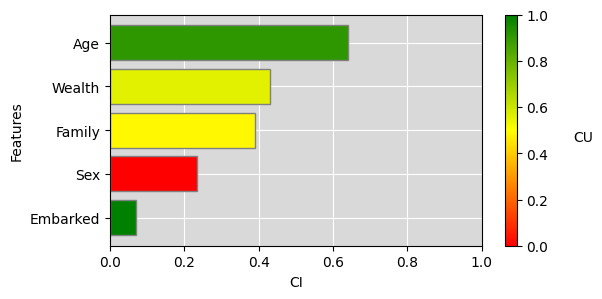

In [26]:
CIU_titanic.plot_ciu(top_res, figsize=(6,3))

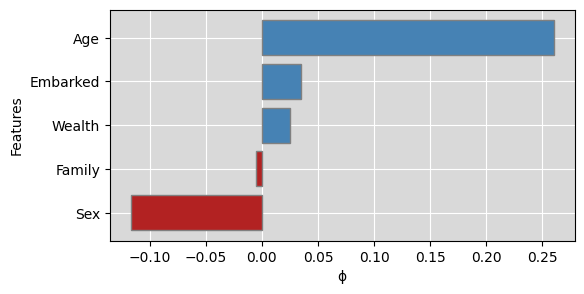

In [27]:
CIU_titanic.plot_influence(top_res, figsize=(6,3))

In [28]:
print(CIU_titanic.textual_explanation(top_res))

The explained value is Yes with the value 0.64 (CU=0.64), which is higher than average utility.
Feature Wealth has normal importance (CI=0.43) and has value(s) [ 1 72], which is higher than average utility (CU=0.56)
Feature Family has low importance (CI=0.39) and has value(s) [0 0], which is lower than average utility (CU=0.49)
Feature Sex has low importance (CI=0.23) and has value(s) 1, which is low utility (CU=0.00)
Feature Age has high importance (CI=0.64) and has value(s) 8, which is high utility (CU=0.91)
Feature Embarked has very low importance (CI=0.07) and has value(s) 1, which is high utility (CU=1.00)



,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
SibSp,0.589744,0.826087,0.192308,Yes,0.64,SibSp,0.45,0.68,[3],[0],0.5,Family,"[3, 4]"
Parch,0.410256,0.000000,-0.205128,Yes,0.64,Parch,0.64,0.80,[4],[0],0.5,Family,"[3, 4]"


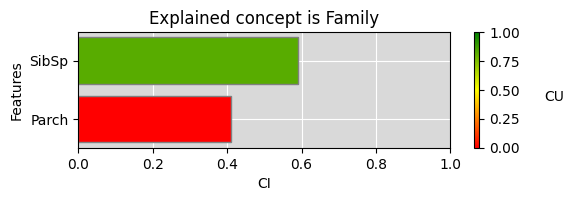

In [29]:
res = CIU_titanic.explain(new_passenger, output_inds=1, target_concept="Family", nsamples=1000)
display(res)
CIU_titanic.plot_ciu(res, figsize=(6,1.5), main="Explained concept is Family")

Same thing but with re-using the already calculated CIU result for "Family". Remark: The "target_ciu" must have been obtained for the same "output_inds" parameter value as in this call!

,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
SibSp,0.589744,0.826087,0.192308,Yes,0.64,SibSp,0.45,0.68,[3],[0],0.5,Family,"[3, 4]"
Parch,0.410256,0.000000,-0.205128,Yes,0.64,Parch,0.64,0.80,[4],[0],0.5,Family,"[3, 4]"


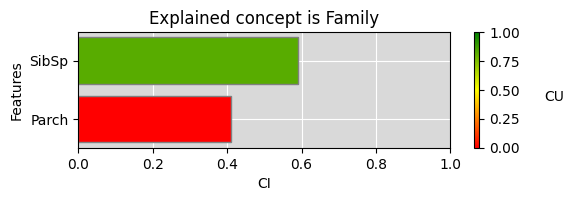

In [30]:
res = CIU_titanic.explain(new_passenger, output_inds=1, target_concept="Family", target_ciu=top_res, nsamples=1000)
display(res)
CIU_titanic.plot_ciu(res, figsize=(6,1.5), main="Explained concept is Family")

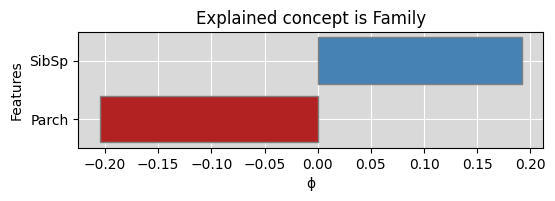

In [31]:
CIU_titanic.plot_influence(res, figsize=(6,1.5), main="Explained concept is Family")

In [32]:
from IPython.display import Markdown
markdown_text = CIU_titanic.textual_explanation(res, target_ciu=top_res, use_markdown_effects=True)
Markdown(markdown_text)

The explained value is ***Family*** for output ***Yes***, which has **low importance (CI=0.39)** and **lower than average utility (CU=0.49)**.<br>Feature *SibSp* has **normal importance (CI=0.59)** and has value(s) 0, which is **high utility (CU=0.83)**<br>Feature *Parch* has **normal importance (CI=0.41)** and has value(s) 0, which is **low utility (CU=0.00)**<br>

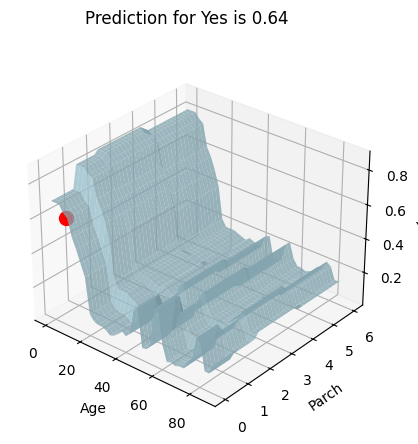

In [33]:
CIU_titanic.plot_3D([2,4], ind_output=1, azim=-50)

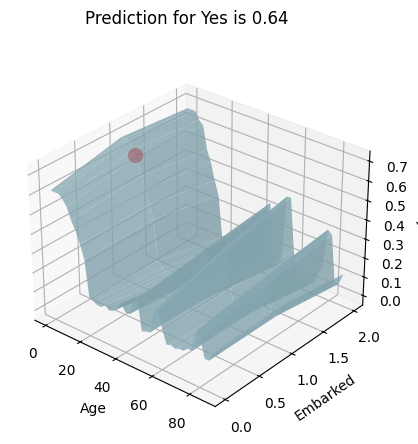

In [34]:
CIU_titanic.plot_3D([2,6], ind_output=1, nbr_pts=(40,3), azim=-50)